In [9]:
import os
import numpy as np
import rasterio
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from glob import glob
from rasterio.transform import from_origin
import re

import geopandas as gpd
from dbfread import DBF
import pandas as pd
from pyproj import CRS
import xml.etree.ElementTree as ET
from IPython.display import display
import xarray as xr


### Gridded Population

In [ ]:
# ✅ Step 1: List and Categorize All Files
data_folder = "Gridded_Population_Density_Data" # The dataset folder where the .ipynb is located

file_types = {"tif": [], "tfw": [], "aux_xml": [], "ovr": [], "others": []}

for file in os.listdir(data_folder):
    if file.endswith(".tif"):
        file_types["tif"].append(file)
    elif file.endswith(".tfw"):
        file_types["tfw"].append(file)
    elif file.endswith(".tif.aux.xml"):
        file_types["aux_xml"].append(file)
    elif file.endswith(".tif.ovr"):
        file_types["ovr"].append(file)
    else:
        file_types["others"].append(file)

print("📂 Dataset File Summary:")
for key, files in file_types.items():
    print(f"   ➡ {key.upper()}: {len(files)} files")

tfw_data_dict = {}

if file_types["tfw"]:
    print("\n✅ Extracting Georeferencing Data from .tfw Files...")
    for tfw_file in file_types["tfw"]:
        with open(os.path.join(data_folder, tfw_file), "r") as f:
            tfw_data = [float(line.strip()) for line in f.readlines()]

        tfw_data_dict[tfw_file] = {
            "Pixel Size X": tfw_data[0],
            "Pixel Size Y": tfw_data[3],
            "Upper Left X": tfw_data[4],
            "Upper Left Y": tfw_data[5],
        }
        print(f"   📍 {tfw_file}: {tfw_data_dict[tfw_file]}")

aux_data_dict = {}

if file_types["aux_xml"]:
    print("\n✅ Extracting Statistics from .aux.xml Files...")
    for aux_file in file_types["aux_xml"]:
        try:
            tree = ET.parse(os.path.join(data_folder, aux_file))
            root = tree.getroot()
        except ET.ParseError:
            print(f"   ❌ Error parsing {aux_file}. Skipping.")
            continue

        hist_min = root.find(".//HistItem/HistMin")
        hist_max = root.find(".//HistItem/HistMax")
        mdi_values = [elem.text for elem in root.findall(".//MDI")]

        aux_data_dict[aux_file] = {
            "Min": hist_min.text if hist_min is not None else "N/A",
            "Max": hist_max.text if hist_max is not None else "N/A",
            "MDI Values": mdi_values,
        }
        print(f"   📊 {aux_file}: {aux_data_dict[aux_file]}")



📂 Dataset File Summary:
   ➡ TIF: 8 files
   ➡ TFW: 3 files
   ➡ AUX_XML: 8 files
   ➡ OVR: 5 files
   ➡ OTHERS: 5 files

✅ Extracting Georeferencing Data from .tfw Files...
   📍 Assaba_Pop_2010.tfw: {'Pixel Size X': 0.0083333333, 'Pixel Size Y': -0.0083333333, 'Upper Left X': -12.8387499505, 'Upper Left Y': 18.3120834571}
   📍 Assaba_Pop_2015.tfw: {'Pixel Size X': 0.0083333333, 'Pixel Size Y': -0.0083333333, 'Upper Left X': -12.8387499505, 'Upper Left Y': 18.3120834571}
   📍 Assaba_Pop_2020.tfw: {'Pixel Size X': 0.0083333333, 'Pixel Size Y': -0.0083333333, 'Upper Left X': -12.8387499505, 'Upper Left Y': 18.3120834571}

✅ Extracting Statistics from .aux.xml Files...
   📊 Assaba_Pop_2010.tif.aux.xml: {'Min': '0.1620030701160431', 'Max': '1225.355590820312', 'MDI Values': ['43613.000000', 'nan']}
   📊 mrt_pd_2000_1km.tif.aux.xml: {'Min': '0', 'Max': '23852.546875', 'MDI Values': ['0', '23852.546875', '2.3570325329055', '58.799808926354', '0.000000', '1298695.000000', '1', '1', None, '345

✅ Found 8 raster files, sorted chronologically.



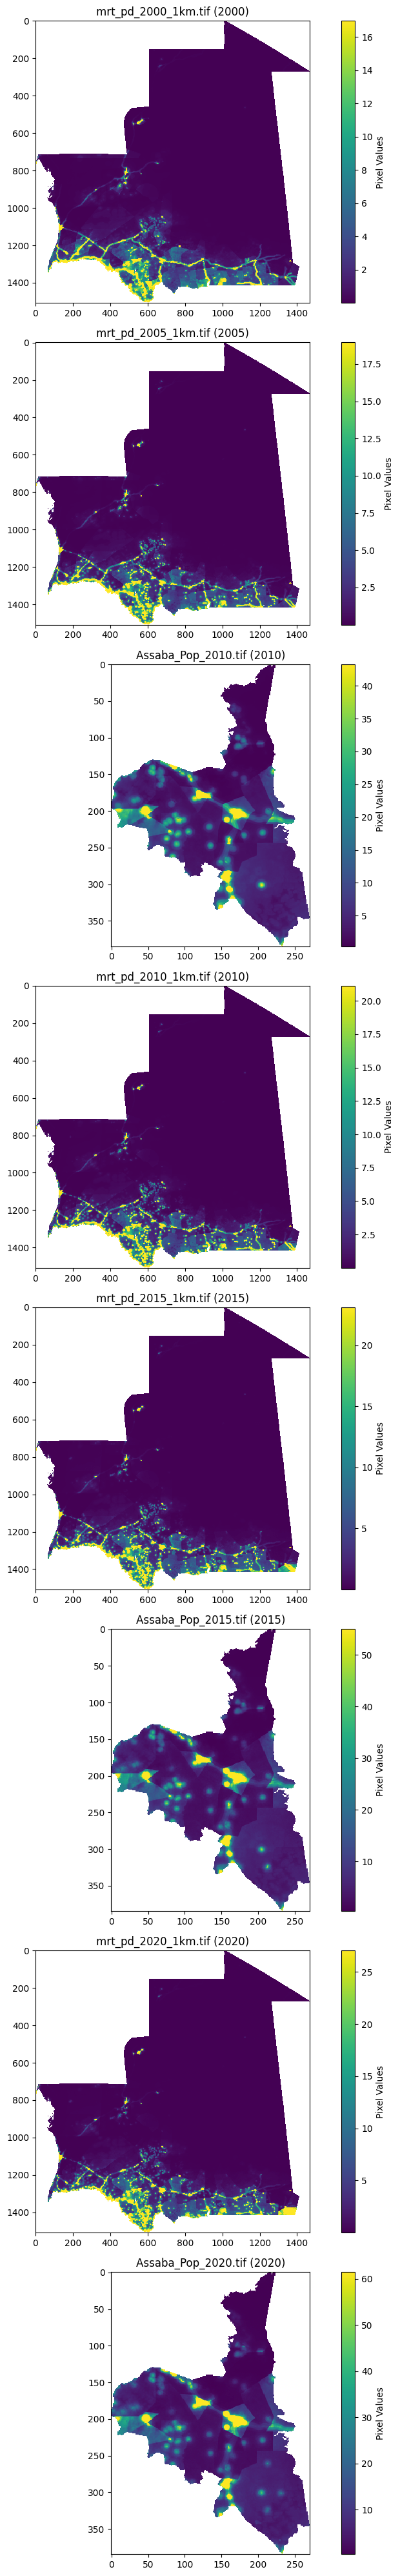

In [ ]:
# ✅ Get all .tif files
data_folder = "Gridded_Population_Density_Data"  # The dataset folder
raster_files = glob(os.path.join(data_folder, "*.tif"))

def extract_year(filename):
    """Extracts the year from the filename using regex."""
    match = re.search(r"(\d{4})", filename)  # Look for 4-digit year
    return int(match.group(1)) if match else 9999  # Default 9999 if no year found

raster_files_sorted = sorted(raster_files, key=lambda x: extract_year(os.path.basename(x)))

if not raster_files_sorted:
    print("❌ No .tif files found.")
else:
    print(f"✅ Found {len(raster_files_sorted)} raster files, sorted chronologically.\n")

    fig, axes = plt.subplots(nrows=len(raster_files_sorted), figsize=(10, 5 * len(raster_files_sorted)))

    if len(raster_files_sorted) == 1:
        axes = [axes]  # Ensure iterable if only one file

    for ax, raster_path in zip(axes, raster_files_sorted):
        with rasterio.open(raster_path) as src:
            raster_data = src.read(1)  # Read first band
            nodata_value = src.nodata  # Get NoData value

            if nodata_value is not None:
                raster_data = np.where(raster_data == nodata_value, np.nan, raster_data)

            min_val = np.nanpercentile(raster_data, 2)  # 2nd percentile
            max_val = np.nanpercentile(raster_data, 98)  # 98th percentile
            raster_data = np.clip(raster_data, min_val, max_val)  # Clip extreme values

            im = ax.imshow(raster_data, cmap="viridis", interpolation="nearest")
            ax.set_title(f"{os.path.basename(raster_path)} ({extract_year(os.path.basename(raster_path))})")
            plt.colorbar(im, ax=ax, label="Pixel Values")

    plt.tight_layout()
    plt.show()

### Admin Layer

#### SHP LAYERS

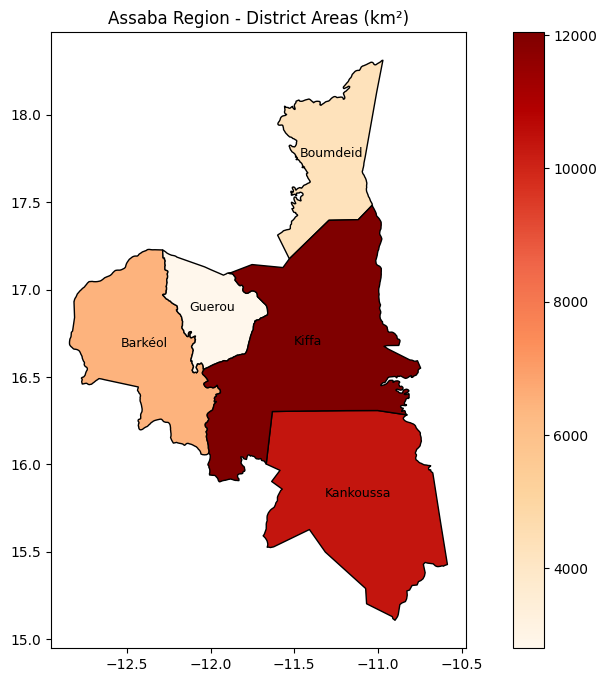

In [ ]:
gdf_Region = gpd.read_file("Admin_layers/Assaba_Region_layer.shp")

fig, ax = plt.subplots(figsize=(12, 8))
gdf_Region.plot(column="AREA_SQKM", cmap="OrRd", legend=True, edgecolor="black", linewidth=1, ax=ax)

for idx, row in gdf_Region.iterrows():
    plt.text(row.geometry.centroid.x, row.geometry.centroid.y, row.ADM2_EN, fontsize=9, ha="center", color="black")

plt.title("Assaba Region - District Areas (km²)")
plt.show()


#### DBF

In [18]:
dbf_path = "Admin_layers/Assaba_Districts_layer.dbf"
table_Districts = DBF(dbf_path, encoding="utf-8")

df_Districts = pd.DataFrame(iter(table_Districts))

df_Districts.to_csv("Assaba_Districts_dbf.csv", index=False)

df_Districts.head

<bound method NDFrame.head of     FID_1      ADM3_EN ADM3_PCODE   ADM3_REF    ADM2_EN ADM2_PCODE ADM1_EN  \
0      71    El Ghabra    MR03106               Barkéol      MR031  Assaba   
1      77       Guerou    MR03301                Guerou      MR033  Assaba   
2      66    Barkeiwel    MR03101               Barkéol      MR031  Assaba   
3      91      Legrane    MR03506                 Kiffa      MR035  Assaba   
4      82         Sani    MR03402             Kankoussa      MR034  Assaba   
5      70      Daghveg    MR03105               Barkéol      MR031  Assaba   
6      73  Bou Lahrath    MR03108               Barkéol      MR031  Assaba   
7      85        Hamed    MR03405             Kankoussa      MR034  Assaba   
8      67      Gueller    MR03102               Barkéol      MR031  Assaba   
9      89    El Melgue    MR03504                 Kiffa      MR035  Assaba   
10     79    El Ghaira    MR03303                Guerou      MR033  Assaba   
11     68      Lebheir    MR03103 

In [20]:
dbf_path = "Admin_layers/Assaba_Region_layer.dbf"

try:
    table_Regions = DBF(dbf_path, encoding="utf-8")
except UnicodeDecodeError:
    table_Regions = DBF(dbf_path, encoding="ISO-8859-1")  # Try Latin-1 if UTF-8 fails

df_Regions = pd.DataFrame(iter(table_Regions))

df_Regions.to_csv("Assaba_Regions_dbf.csv", index=False)

print(df_Regions.head())

   FID_1    ADM2_EN ADM2_PCODE ADM2_REF ADM1_EN ADM1_PCODE     ADM0_EN  \
0      6   Boumdeid      MR032           Assaba       MR03  Mauritania   
1      7  Kankoussa      MR034           Assaba       MR03  Mauritania   
2      8    Barkéol      MR031  Barkeol  Assaba       MR03  Mauritania   
3      4     Guerou      MR033           Assaba       MR03  Mauritania   
4      5      Kiffa      MR035           Assaba       MR03  Mauritania   

  ADM0_PCODE        date     validOn validTo  Shape_Leng  Shape_Area  \
0         MR  2024-03-06  2024-03-27    None    3.975597    0.368397   
1         MR  2024-03-06  2024-03-27    None    4.373495    0.874687   
2         MR  2024-03-06  2024-03-27    None    4.190714    0.546288   
3         MR  2024-03-06  2024-03-27    None    2.499498    0.237509   
4         MR  2024-03-06  2024-03-27    None    6.705719    1.020179   

      AREA_SQKM  
0   4323.851319  
1  10369.305326  
2   6448.722910  
3   2800.699987  
4  12041.829921  


#### PRJ

Converted to a projected CRS (EPSG:32628) so calculations are in meters.

In [57]:
gdf["area_km2"] = gdf.to_crs(epsg=32628).geometry.area / 1e6



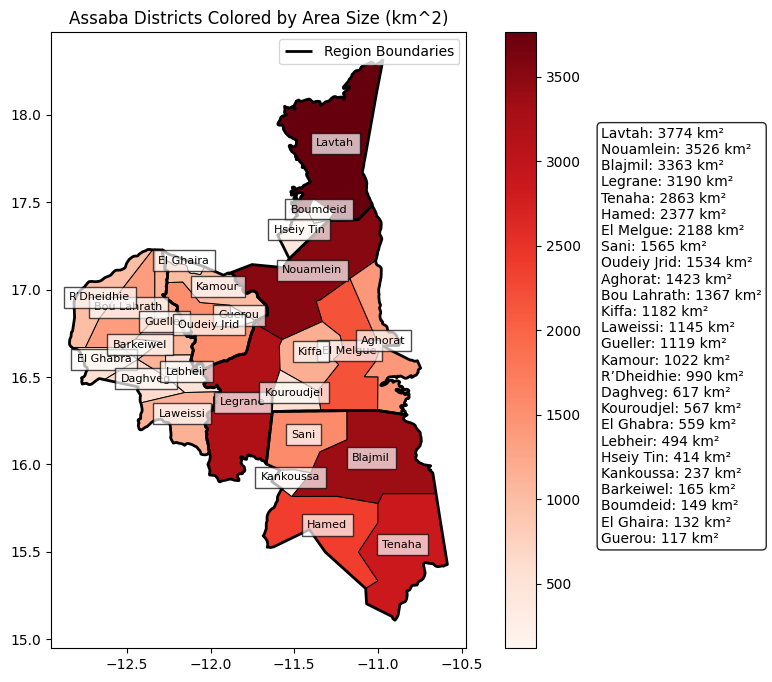

In [3]:
gdf_district = gpd.read_file("Admin_layers/Assaba_Districts_layer.shp")
gdf_region = gpd.read_file("Admin_layers/Assaba_Region_layer.shp")  # Load region boundaries

# Ensure area calculation in km²
gdf_district["area_km2"] = gdf_district.to_crs(epsg=32628).geometry.area / 1e6

# Sort districts by area (largest first)
gdf_sorted = gdf_district.sort_values(by="area_km2", ascending=False)

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the districts, colored by AREA_SQKM
gdf_district.plot(column="AREA_SQKM", cmap="Reds", legend=True, edgecolor="black", linewidth=0.7, ax=ax)

# Overlay region boundaries in red
gdf_region.boundary.plot(ax=ax, color="black", linewidth=2, label="Region Boundaries")

# Add labels (district names)
for idx, row in gdf_district.iterrows():
    plt.text(row.geometry.centroid.x, row.geometry.centroid.y, row.ADM3_EN, 
             fontsize=8, ha="center", color="black", bbox=dict(facecolor="white", alpha=0.7))

# Create a side legend with district names and their sizes
legend_text = "\n".join([f"{row.ADM3_EN}: {row.area_km2:.0f} km²" for _, row in gdf_sorted.iterrows()])
props = dict(boxstyle="round", facecolor="white", alpha=0.85, edgecolor="black")

# Add the text on the right side of the map
plt.gcf().text(0.88, 0.5, legend_text, fontsize=10, ha="left", va="center", bbox=props)

# Title and display
plt.title("Assaba Districts Colored by Area Size (km^2)")
plt.legend()
plt.show()


✅ Found 8 raster files, sorted chronologically.



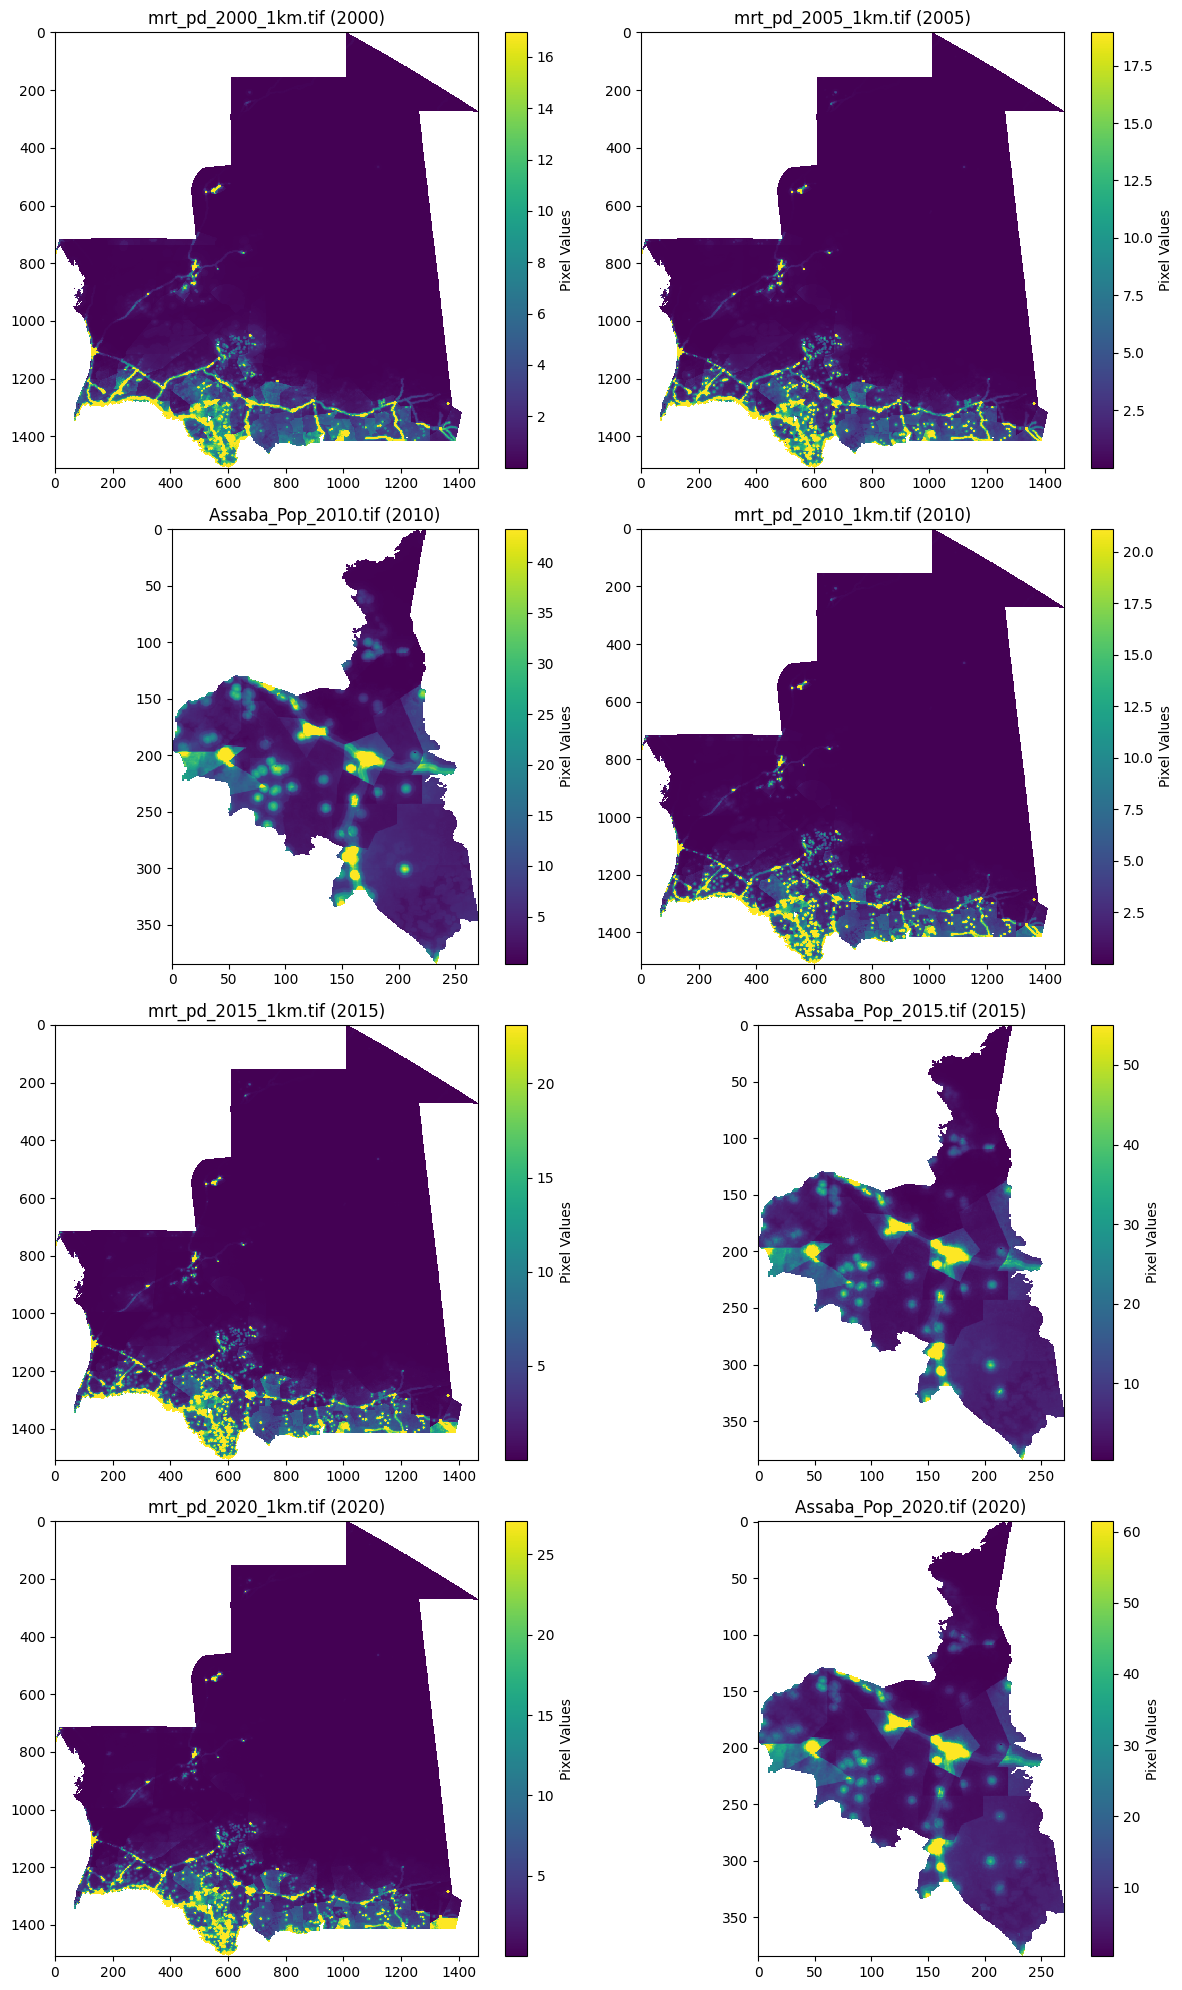

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import os
import re
from glob import glob

# Define the dataset folder
data_folder = "Gridded_Population_Density_Data"

# Get all .tif files in the folder
raster_files = glob(os.path.join(data_folder, "*.tif"))

# Function to extract the year from filename
def extract_year(filename):
    match = re.search(r"(\d{4})", filename)  # Look for a 4-digit year
    return int(match.group(1)) if match else 9999  # Default 9999 if no year

# Sort files by year
raster_files_sorted = sorted(raster_files, key=lambda x: extract_year(os.path.basename(x)))

# Check if files exist
if not raster_files_sorted:
    print("❌ No .tif files found.")
else:
    print(f"✅ Found {len(raster_files_sorted)} raster files, sorted chronologically.\n")

# Create a proper layout (adjustable row/column format)
num_files = len(raster_files_sorted)
cols = 2  # Two plots per row
rows = int(np.ceil(num_files / cols))  # Auto-calculate rows

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 5 * rows))

# Flatten axes for easy iteration if multiple rows exist
axes = axes.flatten() if num_files > 1 else [axes]

# Loop through files and plot
for ax, raster_path in zip(axes, raster_files_sorted):
    with rasterio.open(raster_path) as src:
        raster_data = src.read(1)  # Read first band
        nodata_value = src.nodata  # Get NoData value

        # Handle NoData values
        if nodata_value is not None:
            raster_data = np.where(raster_data == nodata_value, np.nan, raster_data)

        # Normalize values for better visualization
        min_val = np.nanpercentile(raster_data, 2)  # 2nd percentile
        max_val = np.nanpercentile(raster_data, 98)  # 98th percentile
        raster_data = np.clip(raster_data, min_val, max_val)  # Clip extremes

        # Plot raster
        im = ax.imshow(raster_data, cmap="viridis", interpolation="nearest")
        ax.set_title(f"{os.path.basename(raster_path)} ({extract_year(os.path.basename(raster_path))})")
        plt.colorbar(im, ax=ax, label="Pixel Values")

# Hide any unused subplots
for i in range(len(raster_files_sorted), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout and show
plt.tight_layout()
plt.show()


# Streamwater Line and Road Network

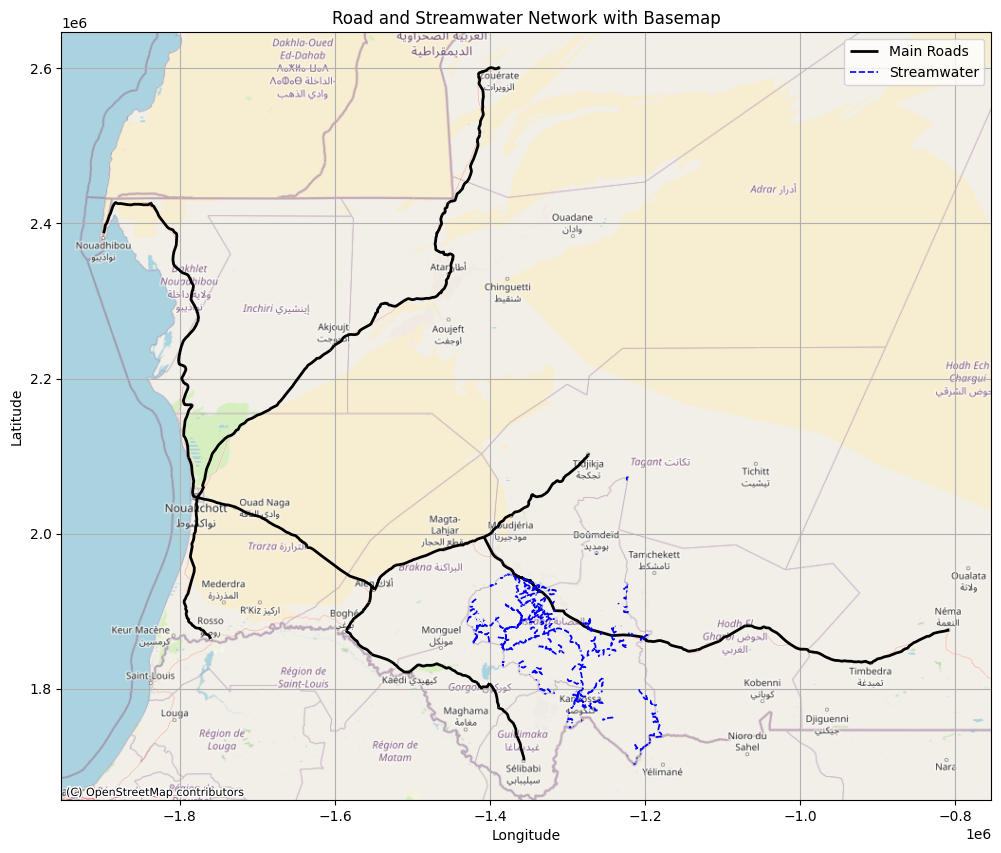

In [95]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx  # Add basemap

# Load the shapefiles
roads_gdf = gpd.read_file("Streamwater_Line_Road_Network/Main_Road.shp")
streams_gdf = gpd.read_file("Streamwater_Line_Road_Network/Streamwater.shp")

# Convert to Web Mercator (required for basemap)
roads_gdf = roads_gdf.to_crs(epsg=3857)
streams_gdf = streams_gdf.to_crs(epsg=3857)

# Create the figure
fig, ax = plt.subplots(figsize=(12, 10))

# Plot roads in black with thicker lines
roads_gdf.plot(ax=ax, color="black", linewidth=2, label="Main Roads")

# Plot streamwater in blue with dashed lines
streams_gdf.plot(ax=ax, color="blue", linewidth=1.2, linestyle="dashed", label="Streamwater")

# Add basemap for better context
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Customize plot
plt.title("Road and Streamwater Network with Basemap")
plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

# Show the map
plt.show()


/var/folders/5x/365fv0fx25sdxt142xcmmqb40000gn/T/ipykernel_943/4147421305.py:24: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_district = gdf_district[gdf_district.intersects(gdf_region.unary_union)]
/var/folders/5x/365fv0fx25sdxt142xcmmqb40000gn/T/ipykernel_943/4147421305.py:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  roads_gdf = roads_gdf[roads_gdf.intersects(gdf_region.unary_union)]
/var/folders/5x/365fv0fx25sdxt142xcmmqb40000gn/T/ipykernel_943/4147421305.py:26: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  streams_gdf = streams_gdf[streams_gdf.intersects(gdf_region.unary_union)]


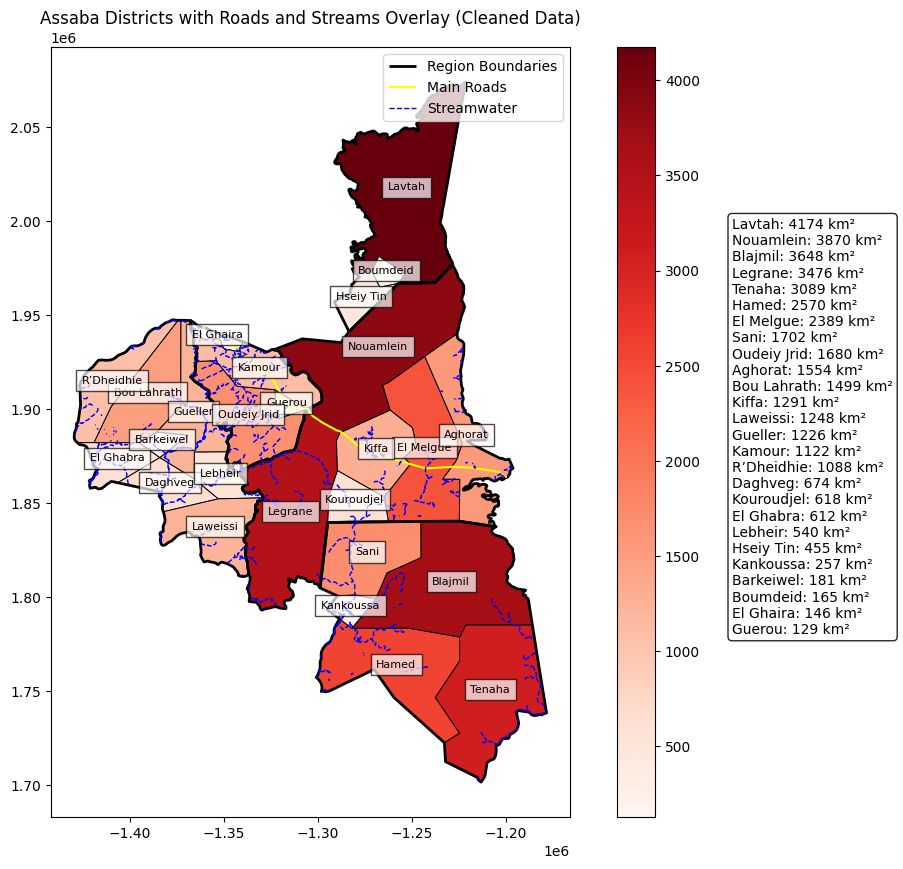

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the district and region shapefiles
gdf_district = gpd.read_file("Admin_layers/Assaba_Districts_layer.shp")
gdf_region = gpd.read_file("Admin_layers/Assaba_Region_layer.shp")

# Load the road and streamwater shapefiles
roads_gdf = gpd.read_file("Streamwater_Line_Road_Network/Main_Road.shp")
streams_gdf = gpd.read_file("Streamwater_Line_Road_Network/Streamwater.shp")

# Ensure all layers use the same CRS (reproject to a common system)
common_crs = "EPSG:3857"  # Web Mercator projection for visualization
gdf_district = gdf_district.to_crs(common_crs)
gdf_region = gdf_region.to_crs(common_crs)
roads_gdf = roads_gdf.to_crs(common_crs)
streams_gdf = streams_gdf.to_crs(common_crs)

# *** STEP 1: CLIP ROADS AND STREAMS TO ASSABA REGION ***
roads_gdf = gpd.clip(roads_gdf, gdf_region)
streams_gdf = gpd.clip(streams_gdf, gdf_region)

# *** STEP 2: REMOVE DATA OUTSIDE ASSABA ***
gdf_district = gdf_district[gdf_district.intersects(gdf_region.unary_union)]
roads_gdf = roads_gdf[roads_gdf.intersects(gdf_region.unary_union)]
streams_gdf = streams_gdf[streams_gdf.intersects(gdf_region.unary_union)]

# Calculate district area in km²
gdf_district["area_km2"] = gdf_district.geometry.area / 1e6

# Sort districts by area (largest first)
gdf_sorted = gdf_district.sort_values(by="area_km2", ascending=False)

# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the districts, colored by AREA_KM2
gdf_district.plot(column="area_km2", cmap="Reds", legend=True, edgecolor="black", linewidth=0.7, ax=ax)

# Overlay region boundaries in blue
gdf_region.boundary.plot(ax=ax, color="black", linewidth=2, label="Region Boundaries")

# Overlay roads in black
roads_gdf.plot(ax=ax, color="yellow", linewidth=1.5, linestyle="-", label="Main Roads")

# Overlay streams in blue
streams_gdf.plot(ax=ax, color="blue", linewidth=1, linestyle="dashed", label="Streamwater")

# Add district labels
for idx, row in gdf_district.iterrows():
    plt.text(row.geometry.centroid.x, row.geometry.centroid.y, row.ADM3_EN,
             fontsize=8, ha="center", color="black", bbox=dict(facecolor="white", alpha=0.7))

# Create a side legend with district names and sizes
legend_text = "\n".join([f"{row.ADM3_EN}: {row.area_km2:.0f} km²" for _, row in gdf_sorted.iterrows()])
props = dict(boxstyle="round", facecolor="white", alpha=0.85, edgecolor="black")

# Add the text on the right side of the map
plt.gcf().text(0.88, 0.5, legend_text, fontsize=10, ha="left", va="center", bbox=props)

# Title and display
plt.title("Assaba Districts with Roads and Streams Overlay (Cleaned Data)")
plt.legend()
plt.show()


### GPP

1. GPP Changes Across Time (Second Image)
There are visible shifts in vegetation, with some areas consistently losing productivity.
2. GPP Distribution Across Years (Third Image)
The density plot shows the distribution of GPP values for different years.
The shape of the distribution remains very similar, indicating that while some areas gain or lose GPP, the overall range of values is stable.
The two peaks suggest two dominant vegetation productivity levels.

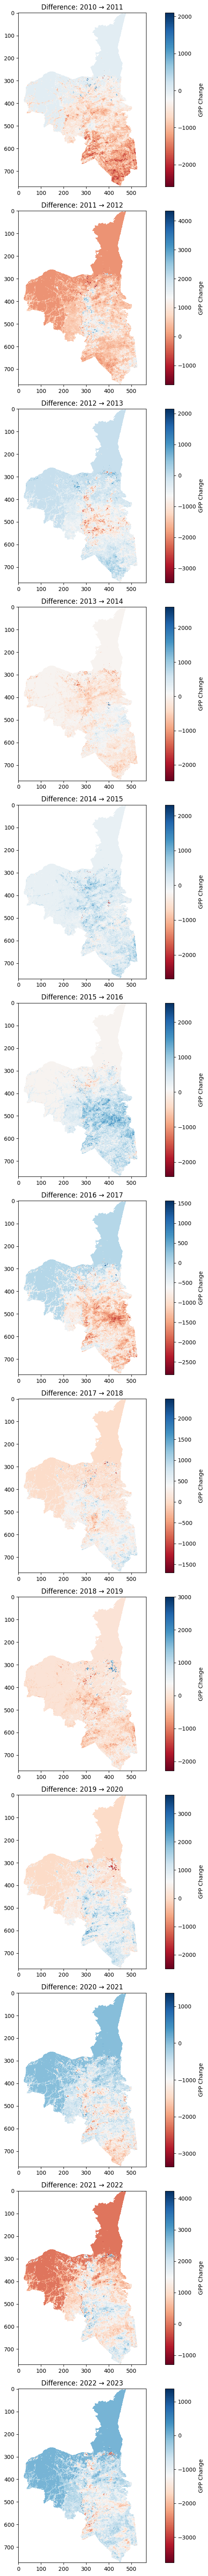

In [35]:


# ✅ Store differences in a list
year_diffs = []

for i in range(len(raster_files) - 1):
    with rasterio.open(raster_files[i]) as src1, rasterio.open(raster_files[i + 1]) as src2:
        data1 = src1.read(1).astype(float)
        data2 = src2.read(1).astype(float)

        # ✅ Handle NoData values
        nodata_value = src1.nodata  
        if nodata_value is not None:
            data1[data1 == nodata_value] = np.nan
            data2[data2 == nodata_value] = np.nan

        # ✅ Compute difference
        diff = data2 - data1
        year_diffs.append((extract_year(raster_files[i]), extract_year(raster_files[i+1]), diff))

# ✅ Plot differences
fig, axes = plt.subplots(len(year_diffs), 1, figsize=(10, 5 * len(year_diffs)))

for ax, (year1, year2, diff) in zip(axes, year_diffs):
    im = ax.imshow(diff, cmap="RdBu", interpolation="nearest")
    ax.set_title(f"Difference: {year1} → {year2}")
    plt.colorbar(im, ax=ax, label="GPP Change")

plt.tight_layout()
plt.show()


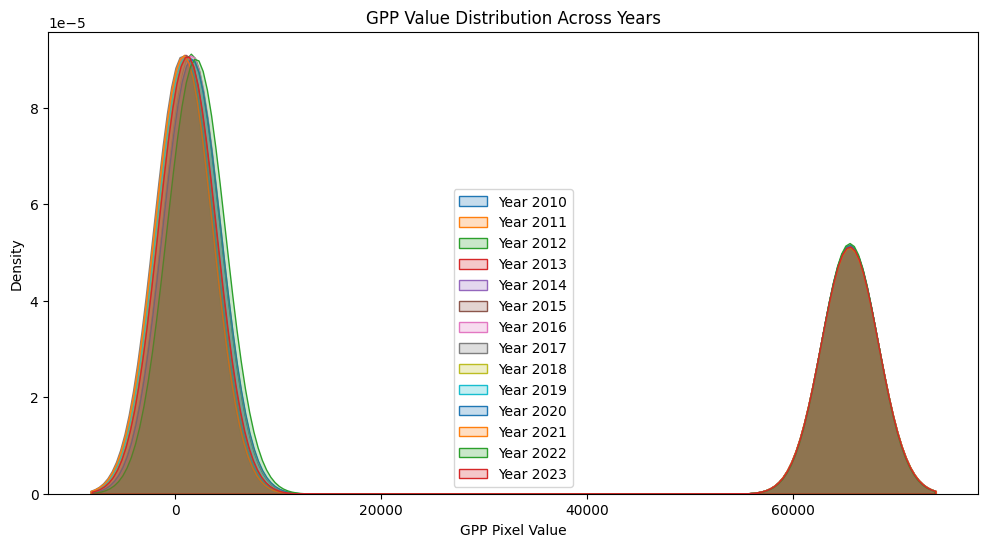

In [36]:

plt.figure(figsize=(12, 6))

for raster_path in raster_files:
    with rasterio.open(raster_path) as src:
        data = src.read(1).astype(float)
        nodata_value = src.nodata  
        if nodata_value is not None:
            data[data == nodata_value] = np.nan

        sns.kdeplot(data.flatten(), label=f"Year {extract_year(raster_path)}", fill=True)

plt.xlabel("GPP Pixel Value")
plt.ylabel("Density")
plt.legend()
plt.title("GPP Value Distribution Across Years")
plt.show()


/Users/kolev/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kolev/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


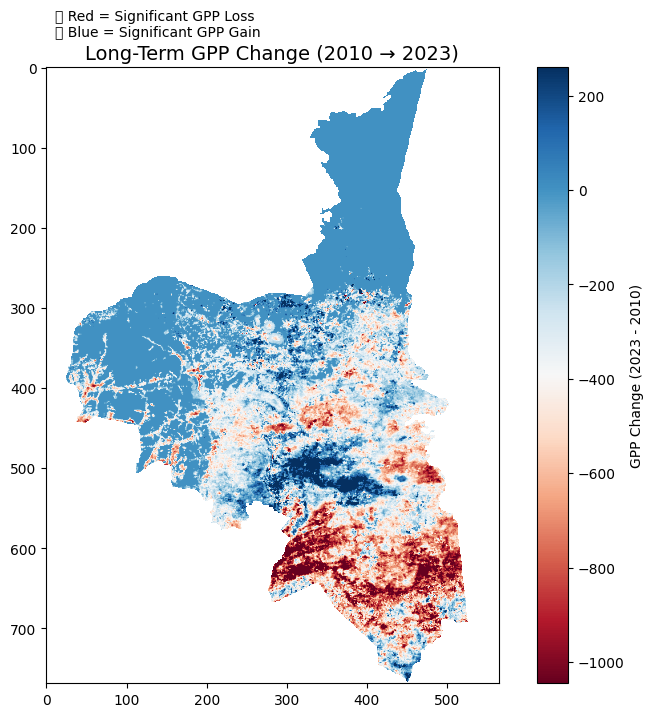

In [37]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Define file paths for the first (2010) and last (2023) years
file_2010 = "MODIS_Gross_Primary_Production_GPP/2010_GP.tif"
file_2023 = "MODIS_Gross_Primary_Production_GPP/2023_GP.tif"

# Load raster data
with rasterio.open(file_2010) as src_2010:
    gpp_2010 = src_2010.read(1).astype(float)
    nodata_2010 = src_2010.nodata

with rasterio.open(file_2023) as src_2023:
    gpp_2023 = src_2023.read(1).astype(float)
    nodata_2023 = src_2023.nodata

# Handle NoData values (convert them to NaN)
if nodata_2010 is not None:
    gpp_2010[gpp_2010 == nodata_2010] = np.nan

if nodata_2023 is not None:
    gpp_2023[gpp_2023 == nodata_2023] = np.nan

# Compute the difference (GPP change)
gpp_change = gpp_2023 - gpp_2010

# Define visualization limits (percentile-based to reduce extreme outliers)
vmin, vmax = np.nanpercentile(gpp_change, [2, 98])

# Plot the change map
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(gpp_change, cmap="RdBu", vmin=vmin, vmax=vmax)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("GPP Change (2023 - 2010)")

# Add interpretation text
ax.set_title("Long-Term GPP Change (2010 → 2023)", fontsize=14)
ax.text(0.02, 1.05, "🔴 Red = Significant GPP Loss\n🔵 Blue = Significant GPP Gain",
        fontsize=10, color="black", ha="left", transform=ax.transAxes,
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"))

plt.show()


Population based on area - Gridded_Population_Density_Data

✅ Found 3 'Assaba_Pop' raster files, sorted chronologically.



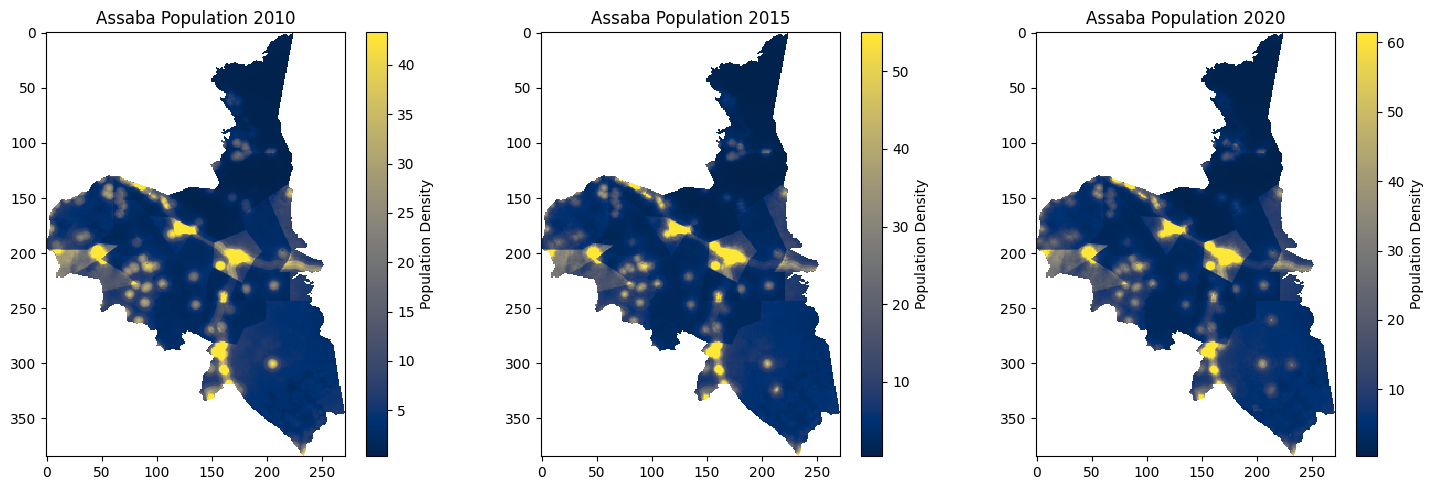

In [22]:


# Define the dataset folder
data_folder = "Gridded_Population_Density_Data"

# Get all .tif files containing "Assaba_Pop"
raster_files = glob(os.path.join(data_folder, "*Assaba_Pop*.tif"))

# Function to extract the year from filename
def extract_year(filename):
    match = re.search(r"(\d{4})", filename)  # Look for a 4-digit year
    return int(match.group(1)) if match else 9999  # Default 9999 if no year

# Sort files by year
raster_files_sorted = sorted(raster_files, key=lambda x: extract_year(os.path.basename(x)))

# Check if files exist
if not raster_files_sorted:
    print("❌ No .tif files with 'Assaba_Pop' found.")
else:
    print(f"✅ Found {len(raster_files_sorted)} 'Assaba_Pop' raster files, sorted chronologically.\n")

# Define layout (3 columns per row)
num_files = len(raster_files_sorted)
cols = 3  # Three plots per row
rows = int(np.ceil(num_files / cols))  # Auto-calculate rows

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 5 * rows))

# Flatten axes for easy iteration if multiple rows exist
axes = axes.flatten() if num_files > 1 else [axes]

# Choose color map (Change this to 'viridis', 'plasma', 'cividis', 'coolwarm', etc.)
colormap = "cividis"  # <-- Change this to try different options

# Loop through files and plot
for ax, raster_path in zip(axes, raster_files_sorted):
    with rasterio.open(raster_path) as src:
        raster_data = src.read(1)  # Read first band
        nodata_value = src.nodata  # Get NoData value

        # Handle NoData values
        if nodata_value is not None:
            raster_data = np.where(raster_data == nodata_value, np.nan, raster_data)

        # Normalize values for better visualization
        min_val = np.nanpercentile(raster_data, 2)  # 2nd percentile
        max_val = np.nanpercentile(raster_data, 98)  # 98th percentile
        raster_data = np.clip(raster_data, min_val, max_val)  # Clip extremes

        # Plot raster
        im = ax.imshow(raster_data, cmap=colormap, interpolation="nearest")
        ax.set_title(f"Assaba Population {extract_year(os.path.basename(raster_path))}")
        plt.colorbar(im, ax=ax, label="Population Density")

# Hide any unused subplots
for i in range(len(raster_files_sorted), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout and show
plt.tight_layout()
plt.show()


Population loss and gain from Gridded_Population_Density_Data

✅ Found 3 'Assaba_Pop' raster files.



/var/folders/5x/365fv0fx25sdxt142xcmmqb40000gn/T/ipykernel_943/3885648229.py:76: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5x/365fv0fx25sdxt142xcmmqb40000gn/T/ipykernel_943/3885648229.py:76: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


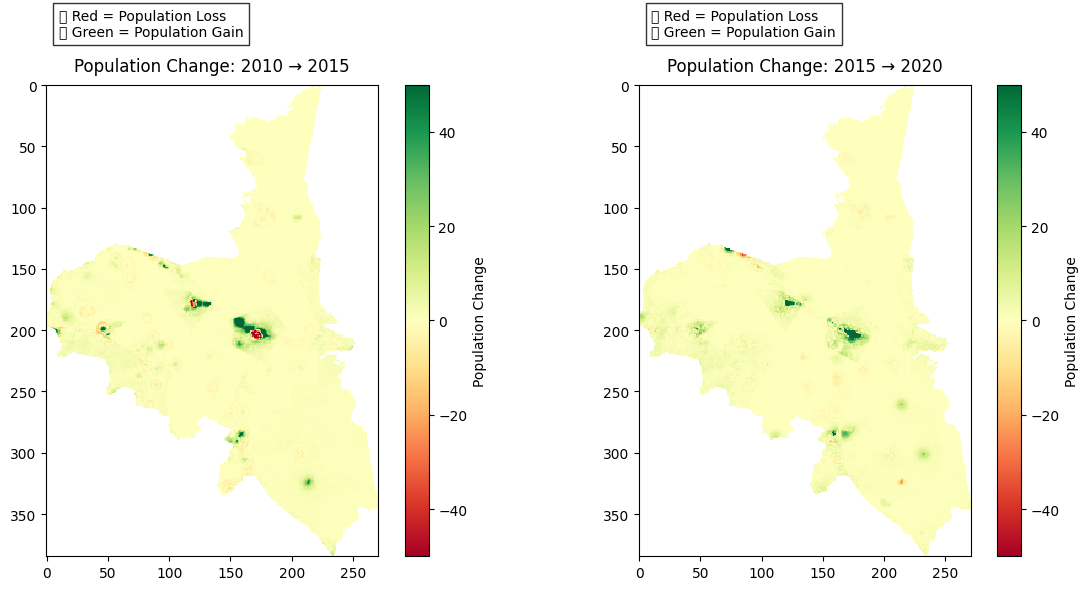

In [31]:

# Define dataset folder
data_folder = "Gridded_Population_Density_Data"

# Get all population raster files containing "Assaba_Pop"
raster_files = glob(os.path.join(data_folder, "*Assaba_Pop*.tif"))

# Function to extract year from filename
def extract_year(filename):
    match = re.search(r"(\d{4})", filename)  # Look for a 4-digit year
    return int(match.group(1)) if match else None  # None if no year

# Sort files by year
raster_files_sorted = sorted(raster_files, key=lambda x: extract_year(os.path.basename(x)))

# Ensure at least 2 files exist for comparison
if len(raster_files_sorted) < 2:
    print("❌ Need at least two years of population data to compare.")
else:
    print(f"✅ Found {len(raster_files_sorted)} 'Assaba_Pop' raster files.\n")

    # List to store population changes
    population_changes = []

    # Compare consecutive years
    for i in range(len(raster_files_sorted) - 1):
        year1_path = raster_files_sorted[i]
        year2_path = raster_files_sorted[i + 1]

        year1 = extract_year(os.path.basename(year1_path))
        year2 = extract_year(os.path.basename(year2_path))

        with rasterio.open(year1_path) as src1, rasterio.open(year2_path) as src2:
            pop1 = src1.read(1).astype(float)  # Read first band
            pop2 = src2.read(1).astype(float)  # Read first band

            # Ensure both rasters have the same shape
            if pop1.shape != pop2.shape:
                print(f"⚠️ Skipping {year1} vs {year2} due to mismatched dimensions.")
                continue

            # Handle NoData values
            pop1[pop1 == src1.nodata] = np.nan
            pop2[pop2 == src2.nodata] = np.nan

            # Compute population change
            delta_population = pop2 - pop1  # Population change

            # Store for later analysis
            population_changes.append((year1, year2, delta_population))

    # ✅ Visualization: Display in one row
    num_comparisons = len(population_changes)
    fig, axes = plt.subplots(nrows=1, ncols=num_comparisons, figsize=(6 * num_comparisons, 6))

    if num_comparisons == 1:
        axes = [axes]  # Ensure iterable if only one comparison

    for ax, (year1, year2, delta_population) in zip(axes, population_changes):
        im = ax.imshow(delta_population, cmap="RdYlGn", interpolation="nearest", vmin=-50, vmax=50)
        ax.set_title(f"Population Change: {year1} → {year2}", fontsize=12, pad=10)
        plt.colorbar(im, ax=ax, label="Population Change")

        # ✅ Adjusted annotation text placement
        ax.text(10, -40,  
                "🔴 Red = Population Loss\n🟢 Green = Population Gain", 
                fontsize=10, color="black", ha="left", 
                bbox=dict(facecolor="white", alpha=0.8, edgecolor="black"))

    plt.tight_layout()
    plt.show()


Climate 


    Year        Min         Max        Mean         Std
0   2010  85.283066  500.844238  358.480469  103.715736
1   2011  41.763184  367.005219  200.431107   76.594688
2   2012  55.942513  609.383789  351.676025  136.251846
3   2013  54.336777  484.157837  261.263092   97.599594
4   2014  40.552017  440.318359  236.406708  103.880470
5   2015  49.812233  500.348663  245.469055  101.996590
6   2016  57.877712  578.630005  295.838470  115.104134
7   2017  45.174648  415.615356  226.643814   91.957329
8   2018  51.860168  542.177856  256.811310  109.753029
9   2019  37.214630  442.896484  187.799301   88.873207
10  2020  53.078060  690.954773  354.370361  160.661987
11  2021  42.870632  441.826813  227.168991   90.530998
12  2022  58.835228  566.629333  315.177399  148.911880
13  2023  52.852234  511.325195  249.563034  103.077087


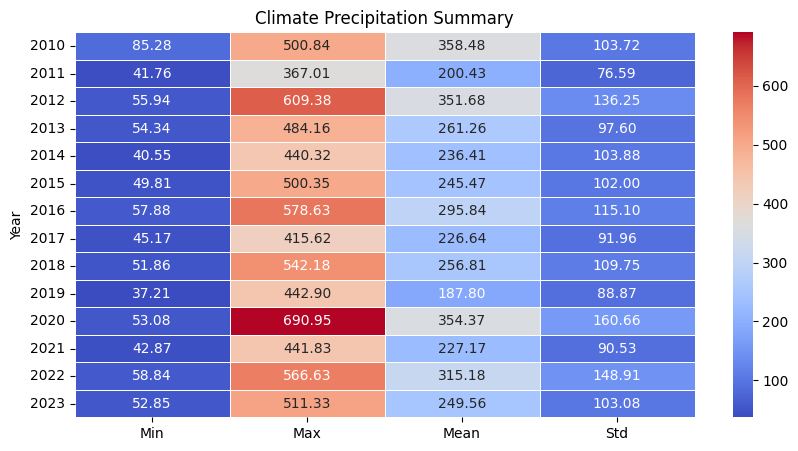

In [42]:
import pandas as pd

# Convert to DataFrame
df_summary = pd.DataFrame(summary_data, columns=["Year", "Min", "Max", "Mean", "Std"])

# Display summary
print(df_summary)  # Print to console

# Save as CSV for external viewing
df_summary.to_csv("Climate_Precipitation_Summary.csv", index=False)

# Display as a formatted table
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.heatmap(df_summary.set_index("Year"), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Climate Precipitation Summary")
plt.show()


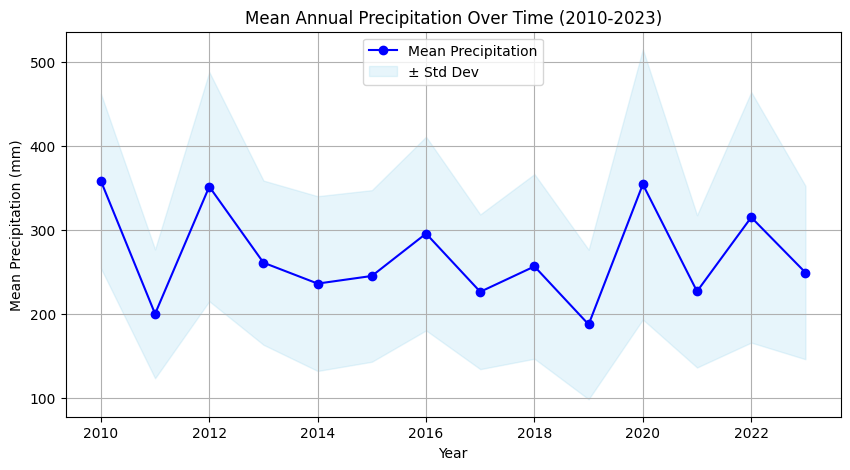

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(df_summary["Year"], df_summary["Mean"], marker="o", linestyle="-", color="blue", label="Mean Precipitation")
plt.fill_between(df_summary["Year"], df_summary["Mean"] - df_summary["Std"], df_summary["Mean"] + df_summary["Std"], alpha=0.2, color="skyblue", label="± Std Dev")
plt.xlabel("Year")
plt.ylabel("Mean Precipitation (mm)")
plt.title("Mean Annual Precipitation Over Time (2010-2023)")
plt.legend()
plt.grid(True)
plt.show()


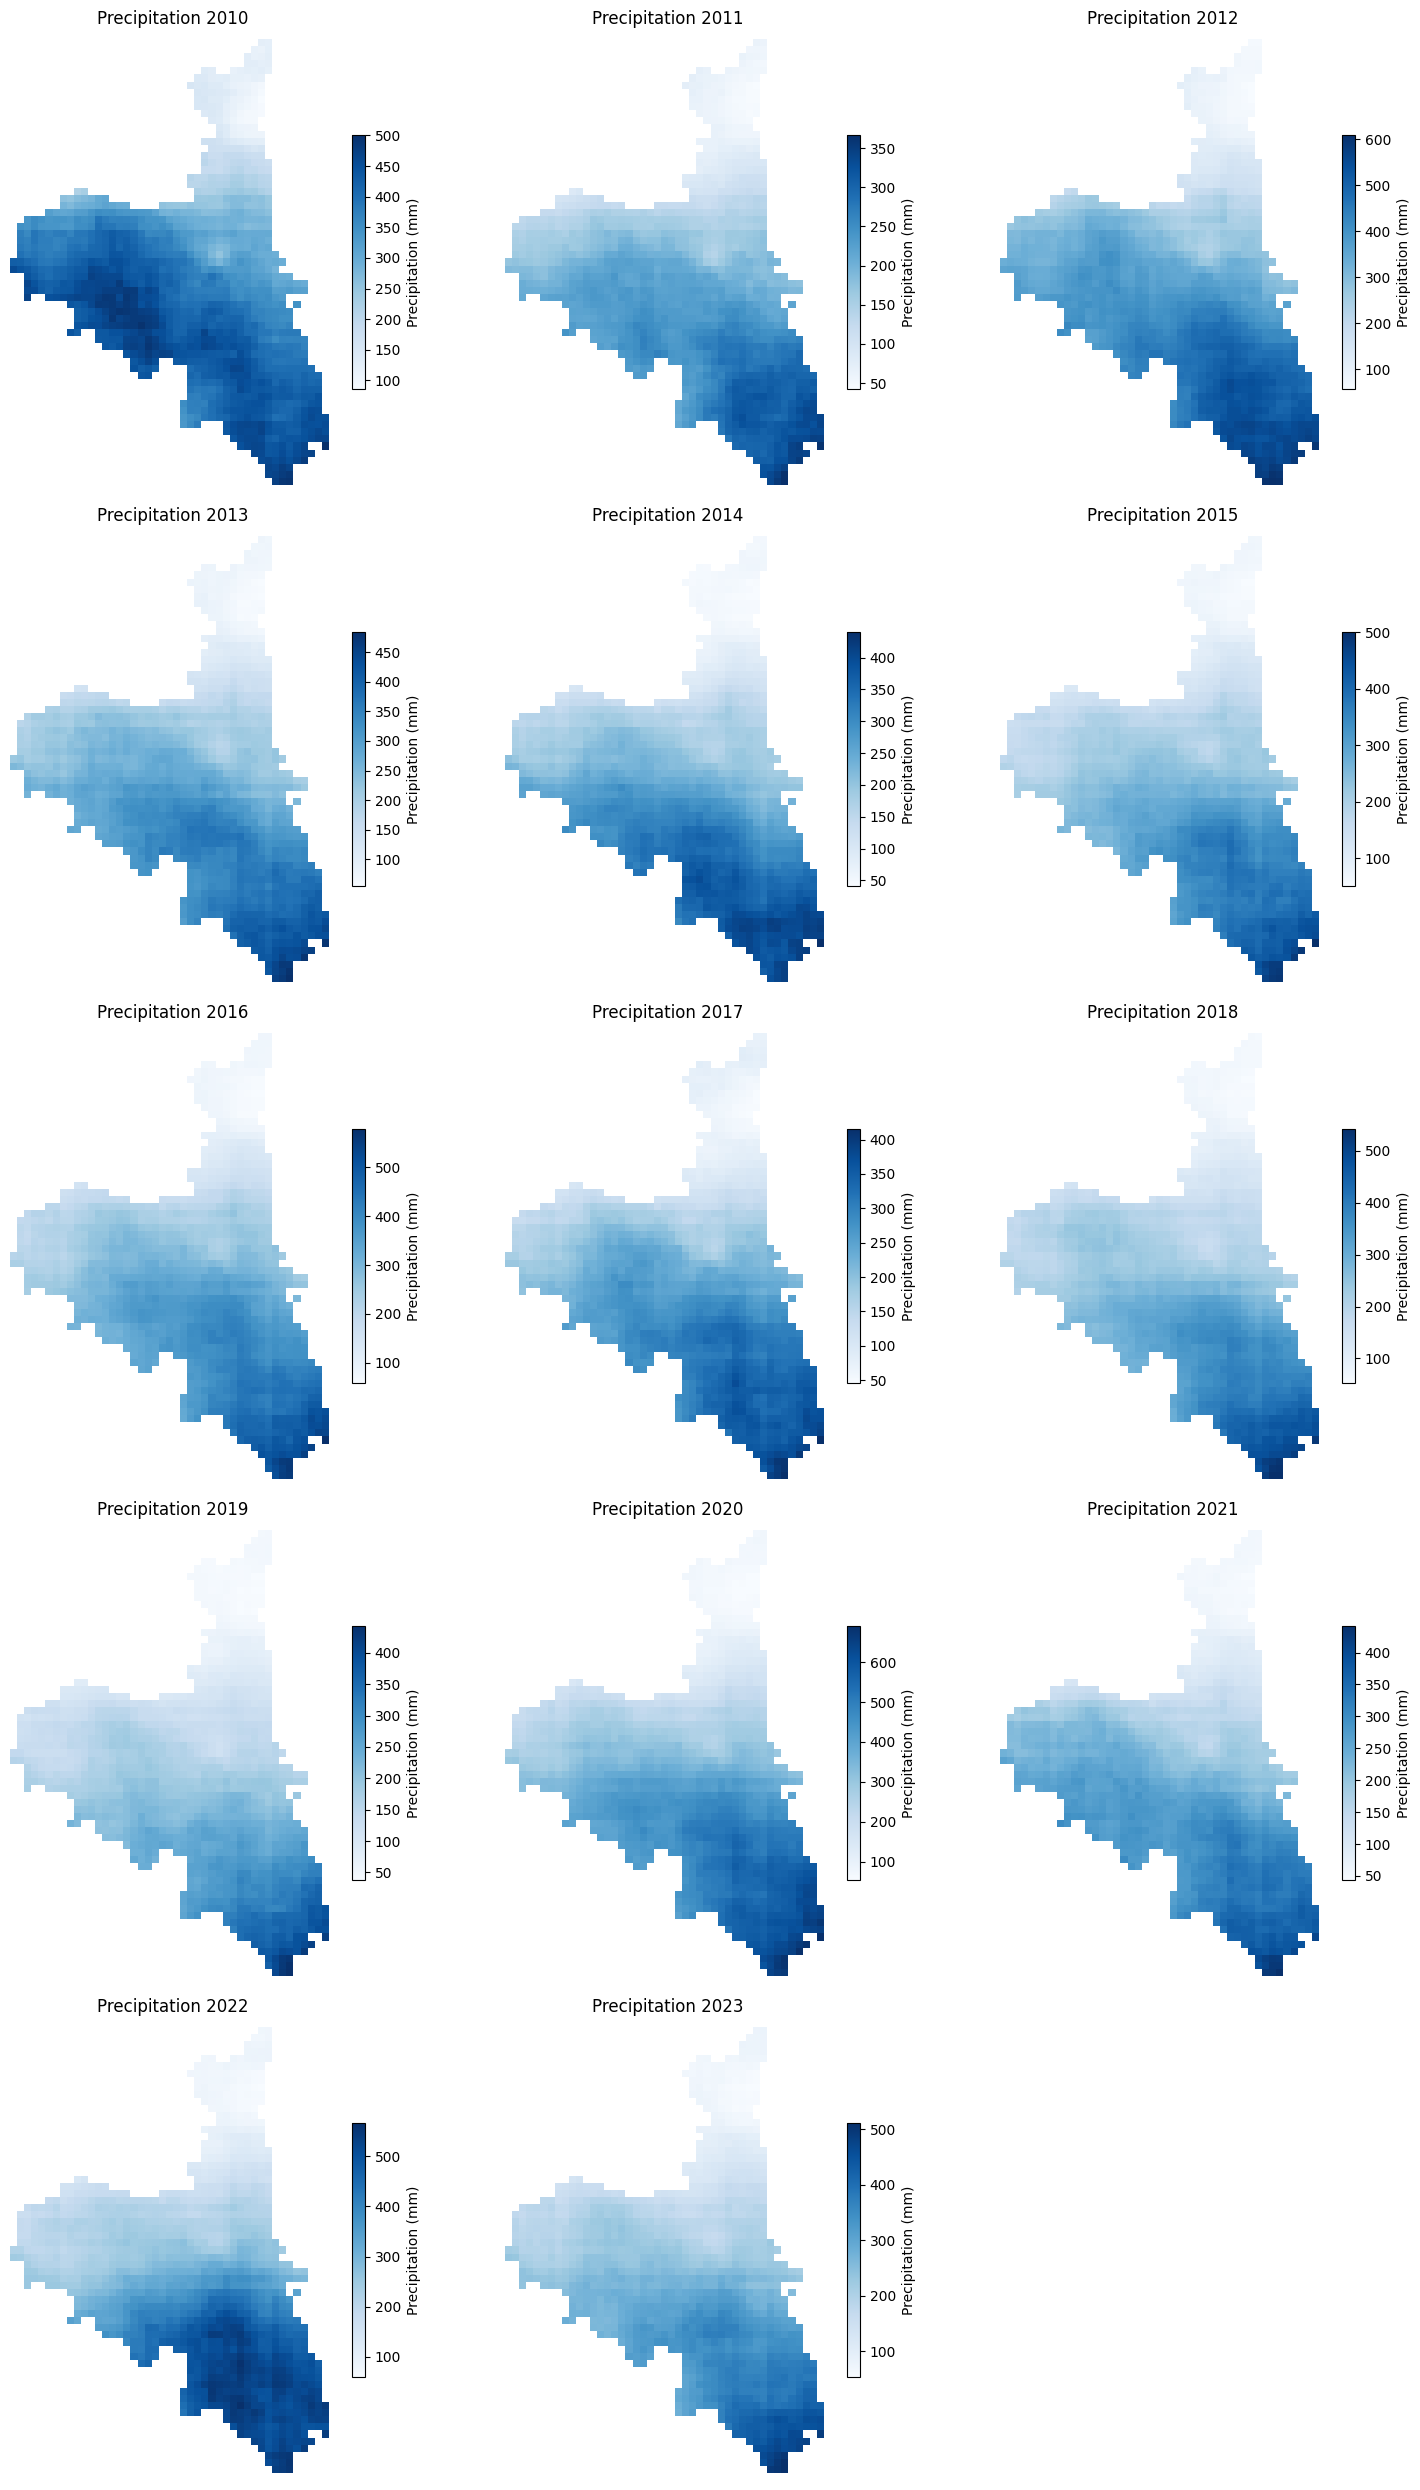

In [40]:
cols = 3  
rows = (len(raster_files_sorted) + cols - 1) // cols  # Arrange plots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for i, raster_path in enumerate(raster_files_sorted):
    with rasterio.open(raster_path) as src:
        raster_data = src.read(1)
        nodata_value = src.nodata

        if nodata_value is not None:
            raster_data = np.where(raster_data == nodata_value, np.nan, raster_data)

        ax = axes[i]
        im = ax.imshow(raster_data, cmap="Blues", interpolation="nearest")
        ax.set_title(f"Precipitation {extract_year(raster_path)}")
        ax.axis("off")

        plt.colorbar(im, ax=ax, fraction=0.03, pad=0.04, label="Precipitation (mm)")

# Remove empty plots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Found 14 raster files.


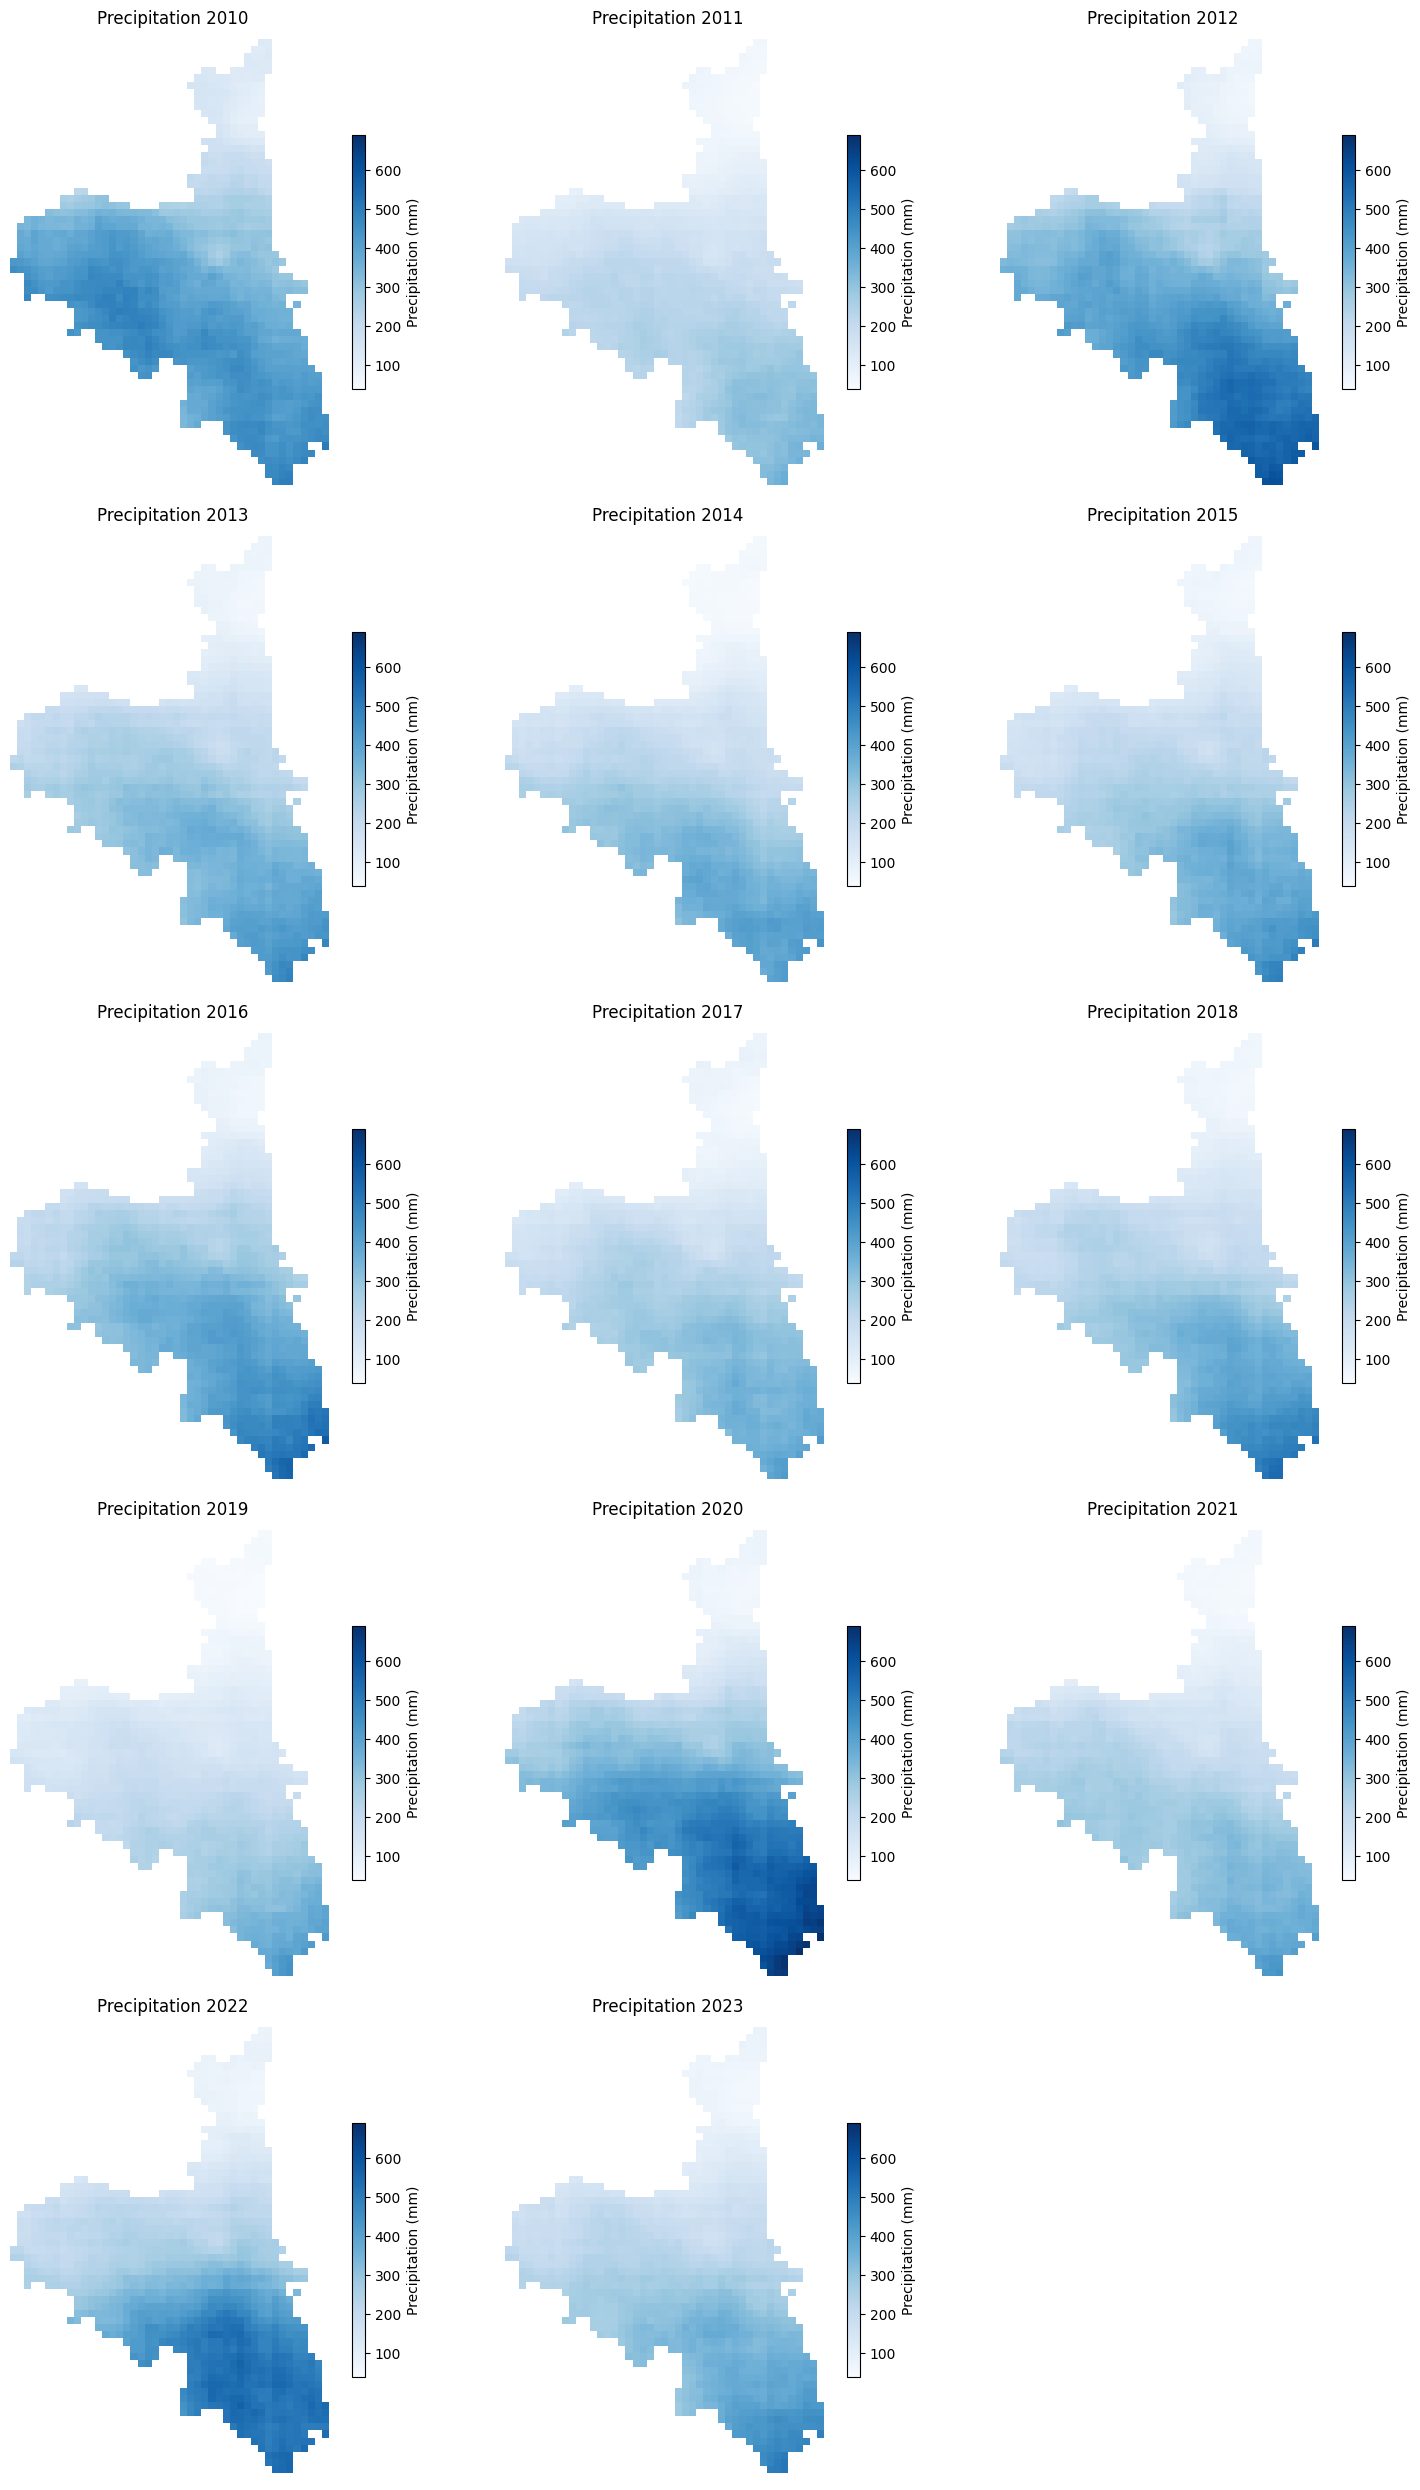

In [49]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# Get raster files
data_folder = "Climate_Precipitation_Data"  # Adjust folder path if needed
raster_files = glob(os.path.join(data_folder, "*.tif"))

# Function to extract year
def extract_year(filename):
    return int(os.path.basename(filename)[:4])  # Assuming format: "2010R.tif"

# Sort by year
raster_files_sorted = sorted(raster_files, key=extract_year)

# Check if files exist
if not raster_files_sorted:
    print("No raster files found!")
else:
    print(f"Found {len(raster_files_sorted)} raster files.")

# Grid settings
cols = 3  
rows = (len(raster_files_sorted) + cols - 1) // cols  # Arrange plots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

# Track global min/max for consistent color scale
global_min, global_max = float('inf'), float('-inf')

# Find global min and max across all images
for raster_path in raster_files_sorted:
    try:
        with rasterio.open(raster_path) as src:
            raster_data = src.read(1)
            nodata_value = src.nodata
            if nodata_value is not None:
                raster_data = np.where(raster_data == nodata_value, np.nan, raster_data)

            if not np.isnan(raster_data).all():  # Avoid empty plots
                global_min = min(global_min, np.nanmin(raster_data))
                global_max = max(global_max, np.nanmax(raster_data))
    except Exception as e:
        print(f"Error reading {raster_path}: {e}")

# Plot each raster
for i, raster_path in enumerate(raster_files_sorted):
    try:
        with rasterio.open(raster_path) as src:
            raster_data = src.read(1)
            nodata_value = src.nodata
            if nodata_value is not None:
                raster_data = np.where(raster_data == nodata_value, np.nan, raster_data)

            if np.isnan(raster_data).all():
                print(f"Skipping empty raster: {raster_path}")
                continue

            ax = axes[i]
            im = ax.imshow(raster_data, cmap="Blues", interpolation="nearest", vmin=global_min, vmax=global_max)
            ax.set_title(f"Precipitation {extract_year(raster_path)}")
            ax.axis("off")

            plt.colorbar(im, ax=ax, fraction=0.03, pad=0.04, label="Precipitation (mm)")

    except Exception as e:
        print(f"Error processing {raster_path}: {e}")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


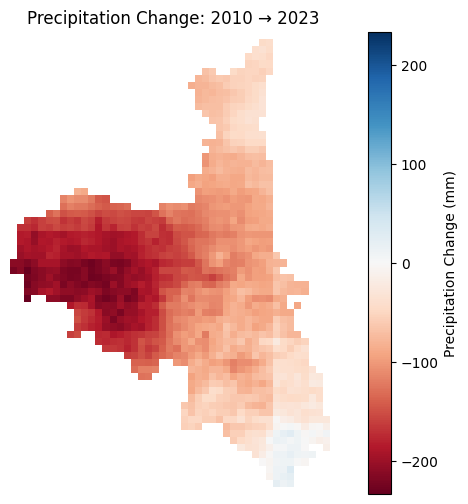

In [41]:
# Select first and last year
first_year_path = raster_files_sorted[0]  # 2010
last_year_path = raster_files_sorted[-1]  # 2023

with rasterio.open(first_year_path) as src1, rasterio.open(last_year_path) as src2:
    data_2010 = src1.read(1)
    data_2023 = src2.read(1)

    # Handle NoData values
    nodata_value = src1.nodata
    if nodata_value is not None:
        data_2010 = np.where(data_2010 == nodata_value, np.nan, data_2010)
        data_2023 = np.where(data_2023 == nodata_value, np.nan, data_2023)

    # Compute precipitation change (2023 - 2010)
    precipitation_change = data_2023 - data_2010

    # Plot change map
    plt.figure(figsize=(8, 6))
    im = plt.imshow(precipitation_change, cmap="RdBu", interpolation="nearest", vmin=-np.nanmax(np.abs(precipitation_change)), vmax=np.nanmax(np.abs(precipitation_change)))
    plt.colorbar(im, label="Precipitation Change (mm)")
    plt.title("Precipitation Change: 2010 → 2023")
    plt.axis("off")
    plt.show()


Land cover

In [51]:
import os
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

# Define the folder
data_folder = "Modis_Land_Cover_Data"

# Get all .tif files
raster_files = glob(os.path.join(data_folder, "*.tif"))

# Function to extract year from filename
def extract_year(filename):
    return int(os.path.basename(filename)[:4])  # Extract YYYY

# Sort files by year
raster_files_sorted = sorted(raster_files, key=extract_year)

# Store land cover statistics
land_cover_summary = {}

for raster_path in raster_files_sorted:
    year = extract_year(os.path.basename(raster_path))
    
    with rasterio.open(raster_path) as src:
        raster_data = src.read(1)  # Read first band
        unique, counts = np.unique(raster_data, return_counts=True)  # Count unique land cover types
        
        # Store in dictionary
        land_cover_summary[year] = dict(zip(unique, counts))

# Convert to DataFrame
df_land_cover = pd.DataFrame(land_cover_summary).T.fillna(0)  # Convert to table format

# Print summary
print("\nLand Cover Summary:")
print(df_land_cover)

# Save to CSV for further analysis if needed
df_land_cover.to_csv("Land_Cover_Summary.csv", index=True)

# Optional: Display first few rows in a Jupyter Notebook
try:
    from IPython.display import display
    display(df_land_cover.head())
except ImportError:
    pass  # For environments without IPython



Land Cover Summary:
          -128       7        10   12   13       16       255
2010  266273.0  2561.0  124304.0  7.0  8.0  41332.0       0.0
2011       0.0  3588.0  119916.0  0.0  8.0  44700.0  266273.0
2012       0.0  2648.0  120942.0  1.0  8.0  44613.0  266273.0
2013       0.0  2560.0  123603.0  0.0  8.0  42041.0  266273.0
2014       0.0  1798.0  122227.0  2.0  8.0  44177.0  266273.0
2015       0.0  1660.0  124966.0  1.0  8.0  41577.0  266273.0
2016       0.0  1422.0  127162.0  7.0  8.0  39613.0  266273.0
2017       0.0  1097.0  125221.0  0.0  8.0  41886.0  266273.0
2018       0.0   939.0  122882.0  1.0  8.0  44382.0  266273.0
2019       0.0   826.0  118631.0  1.0  8.0  48746.0  266273.0
2020       0.0   834.0  120382.0  1.0  8.0  46987.0  266273.0
2021       0.0   995.0  119998.0  1.0  8.0  47210.0  266273.0
2022       0.0   724.0  122864.0  1.0  8.0  44615.0  266273.0
2023       0.0   522.0  123142.0  0.0  8.0  44540.0  266273.0


-128       7        10   12   13       16       255
2010  266273.0  2561.0  124304.0  7.0  8.0  41332.0       0.0
2011       0.0  3588.0  119916.0  0.0  8.0  44700.0  266273.0
2012       0.0  2648.0  120942.0  1.0  8.0  44613.0  266273.0
2013       0.0  2560.0  123603.0  0.0  8.0  42041.0  266273.0
2014       0.0  1798.0  122227.0  2.0  8.0  44177.0  266273.0

### Land cover data into a dataframe

In [67]:
# Path to folder with the TIF files
df_land = "Modis_Land_Cover_Data"

results = []

# Adjust the range to match the years you have
for year in range(2010, 2024):  # up to 2023
    file_name = f"{year}LCT.tif"       # e.g. "2010LCT.tif"
    tif_path = os.path.join(data_dir, file_name)

    try:
        with rasterio.open(tif_path) as src:
            arr = src.read(1)  # read the first (and likely only) band

            # Get the unique class codes and how many times each occurs
            unique_codes, counts = np.unique(arr, return_counts=True)

            # Turn them into a dictionary: {class_code: pixel_count}
            class_counts = dict(zip(unique_codes, counts))

            # Also store the year
            class_counts["year"] = year

            results.append(class_counts)
    except Exception as e:
        print(f"Could not read {tif_path}: {e}")

# Convert the list of dicts into a DataFrame
df_land = pd.DataFrame(results)

# Move "year" into the index (so each row is one year)
df_land.set_index("year", inplace=True)

# Replace any NaNs with 0 (if some years lack certain class codes)
df_land.fillna(0, inplace=True)

print(df_land)

df_land_converted = df_land.reset_index().melt(id_vars=["year"], var_name="class_code", value_name="pixel_count")
df_land_converted.head()



          -128     7      10   12  13     16       255
year                                                  
2010  266273.0  2561  124304  7.0   8  41332       0.0
2011       0.0  3588  119916  0.0   8  44700  266273.0
2012       0.0  2648  120942  1.0   8  44613  266273.0
2013       0.0  2560  123603  0.0   8  42041  266273.0
2014       0.0  1798  122227  2.0   8  44177  266273.0
2015       0.0  1660  124966  1.0   8  41577  266273.0
2016       0.0  1422  127162  7.0   8  39613  266273.0
2017       0.0  1097  125221  0.0   8  41886  266273.0
2018       0.0   939  122882  1.0   8  44382  266273.0
2019       0.0   826  118631  1.0   8  48746  266273.0
2020       0.0   834  120382  1.0   8  46987  266273.0
2021       0.0   995  119998  1.0   8  47210  266273.0
2022       0.0   724  122864  1.0   8  44615  266273.0
2023       0.0   522  123142  0.0   8  44540  266273.0


year class_code  pixel_count
0  2010       -128     266273.0
1  2011       -128          0.0
2  2012       -128          0.0
3  2013       -128          0.0
4  2014       -128          0.0

In [86]:
gdf_district = gpd.read_file("Admin_layers/Assaba_Districts_layer.shp")
gdf_region  = gpd.read_file("Admin_layers/Assaba_Region_layer.shp")

roads_gdf   = gpd.read_file("Streamwater_Line_Road_Network/Main_Road.shp")
streams_gdf = gpd.read_file("Streamwater_Line_Road_Network/Streamwater.shp")


In [87]:
common_crs = "EPSG:3857"  # Web Mercator projection for visualization
gdf_district = gdf_district.to_crs(common_crs)
gdf_region   = gdf_region.to_crs(common_crs)
roads_gdf    = roads_gdf.to_crs(common_crs)
streams_gdf  = streams_gdf.to_crs(common_crs)


In [88]:
roads_gdf = gpd.clip(roads_gdf, gdf_region)
streams_gdf = gpd.clip(streams_gdf, gdf_region)


In [89]:
gdf_district = gdf_district[gdf_district.intersects(gdf_region.unary_union)]
roads_gdf    = roads_gdf[roads_gdf.intersects(gdf_region.unary_union)]
streams_gdf  = streams_gdf[streams_gdf.intersects(gdf_region.unary_union)]


/var/folders/5x/365fv0fx25sdxt142xcmmqb40000gn/T/ipykernel_943/3233838638.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_district = gdf_district[gdf_district.intersects(gdf_region.unary_union)]
/var/folders/5x/365fv0fx25sdxt142xcmmqb40000gn/T/ipykernel_943/3233838638.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  roads_gdf    = roads_gdf[roads_gdf.intersects(gdf_region.unary_union)]
/var/folders/5x/365fv0fx25sdxt142xcmmqb40000gn/T/ipykernel_943/3233838638.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  streams_gdf  = streams_gdf[streams_gdf.intersects(gdf_region.unary_union)]
